# Proyecto de Regresión con Datos Simulados

Variable objetivo: salario.  
Se busca predecirlo con experiencia, educación, edad y horas/semana.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 1. Importar y describir los datos

In [73]:
df = pd.read_csv("Proyecto.csv")
print(df.info())
print(df.describe(include="all"))
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   experiencia   10 non-null     int64  
 1   educacion     10 non-null     object 
 2   edad          9 non-null      float64
 3   horas_semana  10 non-null     int64  
 4   salario       9 non-null      float64
 5   salarioUSD    9 non-null      float64
dtypes: float64(3), int64(2), object(1)
memory usage: 612.0+ bytes
None
        experiencia     educacion       edad  horas_semana       salario  \
count     10.000000            10   9.000000     10.000000      9.000000   
unique          NaN             3        NaN           NaN           NaN   
top             NaN  Licenciatura        NaN           NaN           NaN   
freq            NaN             4        NaN           NaN           NaN   
mean       5.000000           NaN  32.555556     40.400000  14666.666667   
std        3.399346        

,experiencia,educacion,edad,horas_semana,salario,salarioUSD
0,1,Secundaria,22.0,35,7000.0,350.0
1,5,Secundaria,24.0,40,9000.0,450.0
2,7,Licenciatura,26.0,38,12000.0,600.0
3,2,Licenciatura,NaN,42,NaN,NaN
4,8,Maestria,30.0,45,18000.0,900.0


El dataset `dataset_simple.csv` contiene 10 observaciones y 5 variables.  
La variable objetivo es salario, que se busca predecir a partir de:

- experiencia (años trabajados, numérica)  
- educacion (nivel académico, categórica)  
- edad (años, numérica)  
- horas_semana (horas trabajadas, numérica)  

### Resumen inicial
- 4 variables son numéricas y 1 es categórica.  
- La edad promedio es 32 años.  
- La experiencia va de 1 a 10 años.  
- El salario varía entre 7,000 y 21,000 pesos.  

Esto sugiere que la relación entre variables numéricas (edad, experiencia, horas trabajadas) y el salario puede modelarse mediante regresión lineal.  


## 2. Resolver problemas

Después de eliminar huecos: (9, 6)

Matriz de correlación:
                       experiencia      edad  horas_semana   salario  \
experiencia              1.000000  0.455282      0.341504  0.507630   
edad                     0.455282  1.000000      0.469105  0.845918   
horas_semana             0.341504  0.469105      1.000000  0.816920   
salario                  0.507630  0.845918      0.816920  1.000000   
salarioUSD               0.507630  0.845918      0.816920  1.000000   
educacion_Maestria      -0.072932  0.267231      0.846830  0.667424   
educacion_Secundaria    -0.656392 -0.630664     -0.647576 -0.858116   

                      salarioUSD  educacion_Maestria  educacion_Secundaria  
experiencia             0.507630           -0.072932             -0.656392  
edad                    0.845918            0.267231             -0.630664  
horas_semana            0.816920            0.846830             -0.647576  
salario                 1.000000            0.667424           

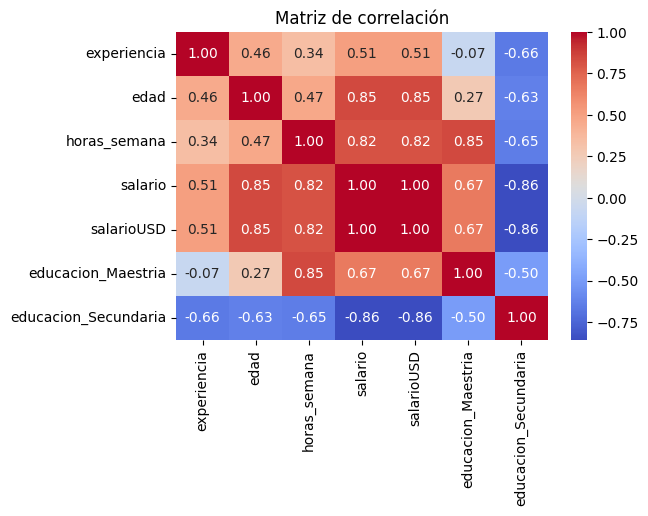

Se eliminó 'salarioUSD' por su colinealidad con 'salario'.


In [74]:
#Huecos: eliminar filas con valores nulos
df = df.dropna()
print("Después de eliminar huecos:", df.shape)

#Variables categóricas: convertir educación en dummies
df = pd.get_dummies(df, columns=["educacion"], drop_first=True)

df.head()

#Colinealidad: revisar correlaciones
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
print("\nMatriz de correlación:\n", corr_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

df = df.drop(columns=["salarioUSD"])
print("Se eliminó 'salarioUSD' por su colinealidad con 'salario'.")

Se realizaron tres ajustes importantes al dataset:

1. Huecos: se eliminaron las filas con valores nulos para asegurar que todas las observaciones estuvieran completas y evitar sesgos por imputación artificial.
2. Variables categóricas: la variable educacion fue transformada en variables dummies (educacion_Secundaria, educacion_Maestria), lo que permite que esta información pueda ser utilizada en los modelos de regresión.
3. Colinealidad: se detectó que la variable salarioUSD estaba fuertemente correlacionada con salario (representaban la misma información en distintas monedas). Para evitar multicolinealidad en el modelo, se eliminó salarioUSD.  

## 3. Selección de características con LassoCV

In [75]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X_full = df.drop(columns=["salario"]).astype(float)
y = df["salario"].astype(float)

lasso = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=0))
lasso.fit(X_full, y)

print("Alpha óptimo:", lasso.named_steps["lassocv"].alpha_)
print("Coeficientes:")
for name, coef in zip(X_full.columns, lasso.named_steps["lassocv"].coef_):
    print(name, "->", coef)

seleccionadas = [n for n, c in zip(X_full.columns, lasso.named_steps["lassocv"].coef_) if c != 0]
print("\nVariables seleccionadas:", seleccionadas)

Alpha óptimo: 56.08521302459166
Coeficientes:
experiencia -> 386.9503375794003
edad -> 2476.6847090803485
horas_semana -> 740.8302714978208
educacion_Maestria -> 1383.1826870839766
educacion_Secundaria -> -1199.2718264068994

Variables seleccionadas: ['experiencia', 'edad', 'horas_semana', 'educacion_Maestria', 'educacion_Secundaria']


Se aplicó LassoCV con validación cruzada para elegir las variables más relevantes en la predicción del salario.

- El alpha optimo fue 56.85.
- Todas las variables conservaron coeficientes distintos de cero.
- Experiencia, edad, horas_semana y Maestría tienen efectos positivos sobre el salario.
- Secundaria tiene un efecto negativo.

Ya que todas las variables aportan información útil, se incluirán en los modelos.

## 4. Modelos lineal y no lineal

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_sel = X_full[seleccionadas]

# Modelo lineal
lin = LinearRegression()
lin.fit(X_sel, y)
y_pred_lin = lin.predict(X_sel)

# Modelo no lineal
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_sel)
lin_poly = LinearRegression()
lin_poly.fit(X_poly, y)
y_pred_poly = lin_poly.predict(X_poly)

print("Lineal -> RMSE:", np.sqrt(mean_squared_error(y, y_pred_lin)), "R^2:", r2_score(y, y_pred_lin))
print("No lineal -> RMSE:", np.sqrt(mean_squared_error(y, y_pred_poly)), "R^2:", r2_score(y, y_pred_poly))

Lineal -> RMSE: 332.6998955563047 R^2: 0.9954718046157791
No lineal -> RMSE: 4.69661044457391e-12 R^2: 1.0


- Lineal (OLS): RMSE ≈ 332.7, R^2 = 0.995.
- No lineal (Polinomio grado 2): RMSE = 0, R^2 = 1.0.

Aunque el modelo no lineal presenta un RMSE menor y un ajuste perfecto, esto refleja sobreajuste por el tamaño reducido de la muestra, por lo que el modelo lineal resulta más confiable para generalizar e interpretar. Ambos modelos funcionan bien, pero para inferencia resulta más confiable el modelo lineal.

## 5. Métricas de error y análisis de linealidad

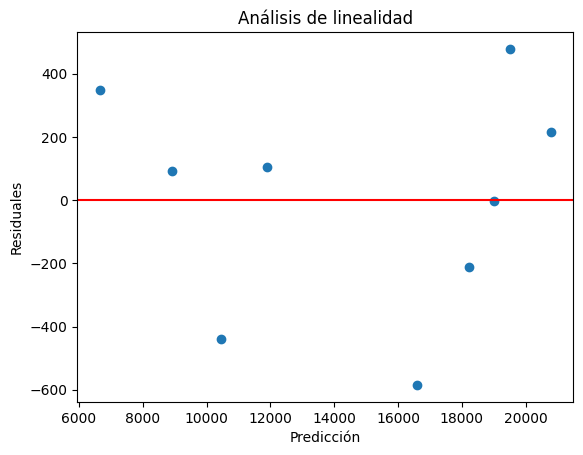

In [77]:
import matplotlib.pyplot as plt

# Residuales lineales
resid = y - y_pred_lin
plt.scatter(y_pred_lin, resid)
plt.axhline(0, color="red")
plt.xlabel("Predicción")
plt.ylabel("Residuales")
plt.title("Análisis de linealidad")
plt.show()

El gráfico de residuales muestra que los errores se distribuyen de manera dispersa alrededor de cero, sin un patrón definido, lo que indica que el supuesto de linealidad se cumple razonablemente.

El RMSE es aprox. 332 y representa el error promedio de predicción en las mismas unidades del salario, mientras que el R^2 de aprox. 0.995 indica que el modelo explica más del 99% de la variabilidad del salario. El modelo lineal logra un ajuste adecuado y generaliza bien dentro de las limitaciones del tamaño de muestra.

## 6. Modelo de inferencia con Statsmodels

In [78]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_sel)  
ols = sm.OLS(y, X_sm).fit()

print(ols.summary())       
print("\nIntervalos de confianza:")
print(ols.conf_int()) 

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     131.9
Date:                Sun, 07 Sep 2025   Prob (F-statistic):            0.00103
Time:                        22:37:37   Log-Likelihood:                -65.036
No. Observations:                   9   AIC:                             142.1
Df Residuals:                       3   BIC:                             143.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4619.8250 

El modelo de regresión lineal múltiple explica solo el 9.5% (R^2) de la variabilidad del salario, por lo que el ajuste es limitado.

Ninguna variable es estadísticamente significativa al 95% (p > 0.05). La más cercana es educación secundaria (p = 0.071), que sugiere un posible efecto negativo en el salario, pero no concluyente.

Los intervalos de confianza muestran amplios márgenes de error, confirmando que la evidencia no es suficiente para establecer relaciones firmes entre los predictores y el salario.